# Demo guide for package minplascalc

Welcome to minplascalc, a Python 3 package to assist with calculations of equilibrium compositions and thermophysical properties of thermal plasmas of the sort typically encountered in metallurgical processing applications.

## Quick links

*Worked examples on general utilities and species calculations*
* <a href="#3.1a">Add a new monatomic species data entry</a>
* <a href="#3.1b">Add a new diatomic species data entry</a>
* <a href="#3.2">Calculate species partition functions</a>

*Worked example 1 - oxygen plasma*
* <a href="#3.3">Calculate an equilibrium composition</a>
* <a href="#3.4">Calcluate density and heat capacity at equilibrium</a>

*Worked example 2 - silicon & carbon monoxide plasma*
* <a href="#3.5">Calculate an equilibrium composition</a>
* <a href="#3.6">Calcluate density and heat capacity at equilibrium</a>

## 1. Target audience

Plasma technology researchers and professionals with a basic knowledge of the Python programming language.

## 2. Description

Ionised gases or <i>plasmas</i> are used in many industrial applications such as arc welding, plasma spraying, and electric furnace metallurgy. Engineering plasmas typically operate at atmospheric pressures and temperatures of the order of 10<sup>4</sup> K. Thermal plasmas of the sort considered here are assumed to be in local thermodynamic equilibirum (LTE), meaning that a single unique temperature can be used to describe them (as opposed to two-temperature plasmas in which the electron temperature is distinct from the heavy-particle temperature). A major advantage of the LTE approximation is that all thermophysical properties of an equilibrium mixture of an arbitrary number of plasma species can be expressed as (complicated) functions of temperature and pressure only.

Knowledge of these thermophysical properties is of great value to engineers working in plasma technology. Such information is useful for simple design calculations, and is necessary input data for computational fluid dynamics and magnetohydrodynamics models of plasma systems. The calculation of composition and thence the thermophysical properties of a thermal plasma given some fundamental information about the species present is a well-understood but mathematically and numerically complex process - it is prone to error if performed manually, hence the need for this tool.

Things you <b>can</b> calculate with minplascalc:
* Statistical mechanics partition functions for individual species using information about the energy levels and excited states
* Equilibrium plasma composition in terms of number densities of a specified mixture of species, using the principle of Gibbs free energy minimisation at a specified temperature and pressure
* Density $\rho$, (relative) enthalpy $H$, and heat capacity $C_P$ at equilibrium conditions

Things you <b>can't</b> calculate with minplascalc:
* Compositions or thermophysical properties of two-temperature plasmas
* $C_P$ for arbitrary non-LTE compositions
* Plasmas of complex molecules or molecular ions consisting of more than two atoms
* Plasmas involving negatively-charged ions
* Transport or thermal radiation properties (see future versions though)

The package also includes some basic tools to format and import data for individual species obtained from the NIST Atomic Spectra and Chemistry WebBook databases, and store it for use by future simulations.

### 2.1 Partition functions

The starting point for thermal plasma calculations is generally the statistical mechanics partition functions for each of the species present. Users of minplascalc should not normally need to access these functions explicitly as they are incorporated directly into the composition and thermophysical property calculators, but they are exposed in the API in case the need to do so ever arises.

Recall that the partition function for a particular species is a description of the statistical properties of a collection of atoms or molecules of that species at thermodynamic equilibrium. Partition functions are normally presented as the sum of weighted state probabilities across the possible energy states of the system. In general at moderate plasma temperatures up to a few 10<sup>4</sup> K, a species' total partition function $Q_{tot}$ can be written as the product of several unique partition functions arising from different quantum mechanical phenomena (assuming weak state coupling and no contribution from nuclear states):

$Q_{tot} = Q_t Q_{int} = Q_t Q_e Q_v Q_r$

Here, $Q_t$ is the translational partition function due to the species' ability to move around in space, $Q_{int}$ is the internal partition function due to energy states internal to the particles of the species, $Q_e$ is the electronic partition function due to different possible arrangements of the electron structure of the species, $Q_v$ is the vibrational partition function due to the ability of the bonds in a polyatomic species to vibrate at different energy levels, and $Q_r$ is the rotational partition function due to a species' ability to rotate around its center of mass at different energy levels.

minplascalc distinguishes between three different types of species - monatomic (charged or uncharged single atoms), diatomic (charged or uncharged bonded pairs of atoms), and free electrons. The formulae used for the various partition functions for each are shown in the table below.

<table style="width: 80%;">
<tr><td>*Partition Function*<td>*Monatomic*<td>*Diatomic*<td>*Electron*<tr>
<td>$Q_t$, m<sup>-3</sup>
<td>$${\left ( \frac{2 \pi m_s k_B T}{h^2}\right )}^{\frac{3}{2}}$$
<td>$${\left ( \frac{2 \pi m_s k_B T}{h^2}\right )}^{\frac{3}{2}}$$
<td>$${\left ( \frac{2 \pi m_e k_B T}{h^2}\right )}^{\frac{3}{2}}$$<tr>
<td>$Q_e$, dim'less
<td>$$\sum_j g_j \exp \left(-\frac{E_j}{k_B T}\right)$$
<td>$$g_0$$
<td>$$2$$<tr>
<td>$Q_v$, dim'less
<td>$$1$$
<td>$$\frac{1}{1-\exp\left( -\frac{\omega_e}{k_B T} \right)}$$
<td>$$1$$<tr>
<td>$Q_r$, dim'less
<td>$$1$$
<td>$$\frac{k_B T}{\sigma_s B_e}$$
<td>$$1$$</table>

Here $m_s$ and $m_e$ are the mass of one particle of the species concerned, $k_B$ is Boltzmann's constant, $T$ is temperature, $h$ is Planck's constant, $g_j$ and $E_j$ are the quantum degeneracy and energy of electronic energy level j (with j = 0 being the ground state), and $\omega_e$, $\sigma_s$ and $B_e$ are the vibrational, symmetry, and rotational constants respectively for a diatomic molecule.

### 2.2 Ionisation energy lowering

In general the ionisation energy required to remove a single electron from a particle of a species is a constant for that particular species when considered in isolation. However, in a mixture of different species and free electrons, the ionisation energy is lowered by a small amount due to local electrostatic shielding effects. This affects both the calculation of the partition functions (the summation of electronic state contributions for monatomic species ignores states with energies above the lowered ionisation energy) and the calculation of equilibrium plasma compositions (the equilibrium relationships are defined using the reference energy levels for each species, which in turn depend on the lowered ionisation energies). Ionisation energy lowering is a complex problem in plasma physics, but there exist many approximate methods for quantifying this effect using the theory of Debye-shielded potentials. Provided the same method is used for all species, the calculation errors generally remain small. The ionisation energy lowering calculation is not exposed to the user in the minplascalc API, since it is only required internally for calculation of species partition functions and LTE compositions.

minplascalc uses the analytical solution of Stewart and Pyatt 1966 (see references in README). In this method, the ionisation energy lowering for each species is calculated explicitly using:

$$\frac{\delta E_i}{k_B T} = \frac{\left [ \left (\frac{a_i}{\lambda_D} \right )^3 + 1 \right ]^\frac{2}{3} -1}{2 \left( z^*+1 \right)}$$

where:

<table style="width: 100%;"><tr>
<td>$$z^* = \left ( \frac{\sum z_j^2 n_j}{\sum z_j n_j} \right )_{j \neq e}$$
<td>$$a_i = \left ( \frac{3 \left (z_i + 1 \right )}{4 \pi n_e} \right )^\frac{1}{3}$$
<td>$$\lambda_D = \left ( \frac{k_B T}{4 \pi e^2 \left ( z^* + 1 \right ) n_e} \right )^\frac{1}{2}$$
</table>

Here, $\delta E_i$ is the amount the ionisation energy of species i is lowered by in J, $a_i$ is the ion-sphere radius of species i, $\lambda_D$ is the Debye sphere radius, $z^*$ is the effective charge number in a plasma consisting of a mixture of species of different charges, $z_j$ is the charge number of species j, $n_j$ is the number density (particles per cubic meter) of species j, and $e$ is the electron charge.

### 2.3 Calculation of LTE compositions

Given temperature, pressure, and a set of species present in a plasma (and some information about the elemental composition of the mixture if more than one element is present), the number density of each species at thermodynamic equilibrium can be calculated using the principle of Gibbs free energy minimisation. This is an important intermediate step in calculating the thermopysical properties, and may also be useful in its own right if one is interested in the relative proportions of different species in complex plasmas. It is exposed to the user in the minplascalc API.

To start, recall the definition of Gibbs free energy:

$$G = G^0 + \sum_i \mu_i N_i$$

where $G$ is the Gibbs free energy of a system, $G^0$ is a reference value depending only on temperature and pressure, $\mu_i$ is the chemical potential of species i, and $N_i$ is the absolute number of particles of species i present. In terms of statistical mechanics properties, $\mu_i$ can be represented as:

$$\mu_i = E_i^0 - k_B T \ln \left ( \frac{Q_{tot,i}V}{N_i} \right )$$

where $Q$ is the partition function defined earlier, $E_i^0$ is the reference energy of the species relative to its constituent uncharged atoms (for uncharged monatomic species and electrons $E_i^0=0$, for uncharged diatomic species it is the negative of the dissociation energy, and for charged species it is $E_i^0$ of the species with one fewer charge number plus the lowered ionisation energy of that species), and $V$ is the volume of the system. From the ideal gas law, we have:

$$V = \frac{k_B T \sum_i N_i}{p}$$

where p is the specified pressure of the system. 

A system at equilibrium is characterised by a minimum stationary point in $G$, giving an independent equation for each species i which simplifies to:

$$\frac{\partial G}{\partial N_i} = \mu_i = 0$$

This set of equations must be solved subject to constraints supplied by the conservation of mass of each element present:

$$\sum_i v_{ij} N_i = \eta_j^0$$

where $v_{ij}$ is the stoichiometric coefficient representing the number of atoms of element j present in species i, and $\eta_j^0$ is the (fixed) total number of atoms of element j present in the system, obtained from initial conditions. Together with this, one additional constraint is supplied by the requirement for electroneutrality of the plasma:

$$\sum_i z_i N_i = 0$$

In minplascalc, the previous three sets of equations are solved using an iterative Lagrange multiplier approach to obtain the set of $N_i$ (and hence $n_i = N_i / V$) at LTE starting from an initial guess.

## 3. Worked examples

Some examples and walk-throughs demonstrating how to use various parts of the minplascalc package follow.

### 3.1 Adding a new species entry to your local data store

If you would like to do calculations using a plasma species that you haven't used before, you will need to generate a minplascalc data entry for it first. You only need to do this <i>once</i> - minplascalc will store the species data in a plain-text file formatted using JSON syntax, and it will then be available for use in any of your future calculations.

<a id="3.1a"></a>
#### 3.1a Add a monatomic species

minplascalc has built-in readers for handling data obtained from the energy levels section of NIST Atomic Spectra Database, which can be found at http://physics.nist.gov/PhysRefData/ASD/levels_form.html. The landing page looks like this:

<img src="demoimg/asd_landingpage.png" alt="NIST ASD landing page" style="width: 800px;"/>

You must then specify the atom or ion that you want to retrieve energy level information for. Let's get the data for the singly-charged oxygen cation species O<sup>+</sup>, which is "O II" in spectrographic terminology. Enter the identifier in the Spectrum field on the form:

<img src="demoimg/asd_spectrumidentification.png" alt="Spectrum identification" style="width: 400px;"/>

Make sure you set Level Units to "cm-1", Format Output to "ASCII (text)", and uncheck everything in the output section except Level and J, like this:

<img src="demoimg/asd_retrievalsettings.png" alt="Spectrum identification" style="width: 400px;"/>

Click the Retrieve Data button. You should see a page with the energy levels listed in a plain-text table. Click and drag to select everything from the first energy level line down to the last one before the first ionisation energy entry (these have no J value and are separated in boxes of ASCII dashes). While you're there, make a note of the ionisation energy value.

<table style="border:none!important">
<td><img src="demoimg/asd_leveldata1.png" alt="Spectrum identification" style="height: 400px;"/>
<td><img src="demoimg/asd_leveldata2.png" alt="Spectrum identification" style="height: 400px;"/>
<td><img src="demoimg/asd_leveldata3.png" alt="Spectrum identification" style="height: 400px;"/>
</table>

Copy and paste the selected content into a temporary text file. This has already been done for the oxygen cation, and the raw NIST data file is located at minplascalc/data/species_raw/nist_O+. Running the following code snippet will add a data entry for the O<sup>+</sup> ion to minplascalc:

In [3]:
import minplascalc as mpc

mpc.buildMonatomicSpeciesJSON(
    name="O+",
    stoichiometry={"O": 1},
    molarMass=0.0159994,
    chargeNumber=1,
    ionisationEnergy=283270.9,
    nistDataFile="minplascalc/data/species_raw/nist_O+")


What's happening here? First we import the minplascalc package, then we call a function to build and save the species data entry for us. 

The function takes as arguments the species name (which is also used as the data entry's associated file name), a small dictionary describing the elemental stoichiometry of the species (in this case a single oxygen atom), the molar mass in kg/mol, the charge on the species in units of the fundamental charge (in this case 1 because O<sup>+</sup> is singly charged), the ionisation energy of the species in cm<sup>-1</sup>, and the path to the energy level text file we just generated from the NIST site. Internally to minplascalc the function reads the energy levels from the text file, assembles the species information into a Python dictionary format, and writes it out to a JSON file called "O+.json" on the path you're running this notebook from.

After this process it will be possible to create an O<sup>+</sup> species object in any minplascalc calculation by importing it using either the explicit path to the JSON file, or (preferably) just the name of the species provided the JSON file is stored in any of the standard minplascalc data paths - see later demos for examples.

<a id="3.1b"></a>
#### 3.1b Diatomic species

The procedure for generating a minplascalc data entry for a new diatomic species is more manual since the data required must be retrieved from various locations. The majority of data for a wide range of species is available from the NIST Chemistry WebBook, http://webbook.nist.gov/chemistry/form-ser/. Enter the formula for the diatomic species you're interested in in the search box at the top of the page, and click the Search button. If you're looking for data for charged diatomic ions, make sure the "Exclude ions from the search" box is unchecked. Let's build a data entry for Silicon Monoxide, SiO:

<table>
<td><img src="demoimg/webbook_landingpage.png" alt="NIST Chemistry WebBook" style="height: 300px;"/>
<td><img src="demoimg/webbook_sio.png" alt="SiO WebBook entry" style="height: 300px;"/>
</table>

The first pieces of information needed are the ionisation energy (to turn SiO into SiO<sup>+</sup>) and the bond dissociation energy (to turn SiO into monatomic Si and O), both in units of cm<sup>-1</sup>. The ionisation energy can be found on the "Gas phase ion energetics" link on the Chemistry WebBook species page (usually in units of eV, so remember to convert):

<img src="demoimg/webbook_ionenergetics.png" alt="SiO ionisation energy" style="width: 400px;"/>

The dissociation energy can be found either on the NIST Computational Chemistry Comparison and Benchmark Database (http://cccbdb.nist.gov/introx.asp), or alternatively from chemistry textbooks or other sources. In the case of SiO, the value is 66707.6 cm<sup>-1</sup> (approximately 800 kJ/mol).

We then need some information about the electronic ground state of the molecule, and its vibrational and rotational parameters. To get this, go back to the main page for SiO in the Chemistry WebBook and click on "Constants of diatomic molecules". This gives the parameters of various energetic states of the molecule - we want the ground state with energy $T_e$ = 0, so scroll all the way down to the entry at the very bottom:

<table>
<td><img src="demoimg/webbook_constants1.png" alt="Molecule constants" style="height: 250px;"/>
<td><img src="demoimg/webbook_constants2.png" alt="Ground state level entry" style="height: 250px;"/>
</table>

The electronic degeneracy of the ground state, $g_0$, is given by the superscriped number in the expression in the "State" column - in the case of SiO, it's 1. The vibrational constant $\omega_e$ and rotational constant $B_e$ are read off the appropriate columns for the ground state entry. The symmetry constant $\sigma_s$ takes the value of 1 for heteronuclear molecules like SiO, and 2 for homonuclear molecules like O<sub>2</sub>. Now we have all the information to build a minplascalc data entry for the SiO species, which can be done by running the following code snippet:

In [2]:
import minplascalc as mpc

mpc.buildDiatomicSpeciesJSON(
    name="SiO",
    stoichiometry={"Si": 1, "O": 1},
    molarMass=0.0440849,
    chargeNumber=0,
    ionisationEnergy=92673.11,
    dissociationEnergy=66707.6,
    sigmaS=1,
    g0=1,
    we=1241.55,
    Be=0.7267512)


What's happening here? As before we import the minplascalc package, then we call a function to build and save the species data entry for us. 

The function takes as arguments the species name (which is also used as the data entry's associated file name), a small dictionary describing the elemental stoichiometry of the species (in this case one oxygen and one silicon), the molar mass in kg/mol, the charge on the species in units of the fundamental charge (in this case 0 because SiO is a neutral species), the ionisation and dissociation energies of the species in cm<sup>-1</sup>, and the electronic, vibrational, and rotational energy level parameters looked up from the Chemistry WebBook. Internally to minplascalc the function assembles the species information into a Python dictionary format, and writes it out to a JSON file called "SiO.json" on the path you're running this notebook from.

After this process it will be possible to create an SiO species object in any minplascalc calculation by importing it using either the explicit path to the JSON file, or (preferably) just the name of the species provided the JSON file is stored in any of the standard minplascalc data paths - see later demos for examples.

<a id="3.2"></a>
### 3.2 Calculating partition functions for individual species

Let's calculate and graph the internal and translational partition functions of various oxygen plasma species over a range of temperatures. To do so, just execute the following code snippets in order. The text in between describes what each piece of code is doing. 

We start by importing the modules we need - matplotlib for drawing graphs, numpy for array functions, and of course minplascalc.

In [47]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import minplascalc as mpc

Then, we create some species objects for different oxygen species using their names. This requires that the data files describing the species are stored in one of the minplascalc standard data storage paths.

In [48]:
speciesnames = ["O2", "O", "O+", "O++"]
species = [mpc.species_from_name(n) for n in speciesnames]

Next, we specify a range of temperatures we're interested in calculating the partition functions at - in this case, from 1000 to 25000 K.

In [49]:
temperatures = np.linspace(1000, 25000, 100)

Then calculate the actual partition functions, using the <span style="font-family: 'Courier';">translationalPartitionFunction(T)</span> and <span style="font-family: 'Courier';">internalPartitionFunction(T)</span> functions of a minplascalc Species object. Both of these take temperature T in K as an argument.

In [50]:
tpfuncs = [[sp.translationalPartitionFunction(temperature) 
            for temperature in temperatures]
          for sp in species]
ipfuncs = [[sp.internalPartitionFunction(temperature) 
            for temperature in temperatures]
          for sp in species]

Finally, to visualise the results, plot all the partition functions as a function of temperature over the range specified.

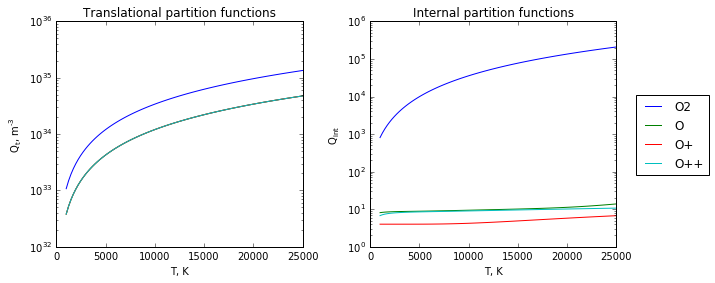

In [51]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
ax0.set_title("Translational partition functions")
ax0.set_xlabel("T, K")
ax0.set_ylabel("$\mathregular{Q_t, m^{-3}}$")
for pf, sn in zip(tpfuncs, speciesnames):
    ax0.semilogy(temperatures, pf, label=sn);
ax1.set_title("Internal partition functions")
ax1.set_xlabel("T, K")
ax1.set_ylabel("$\mathregular{Q_{int}}$")
for pf, sn in zip(ipfuncs, speciesnames):
    ax1.semilogy(temperatures, pf, label=sn);
ax1.legend(bbox_to_anchor=(1.4, 0.7));
plt.tight_layout()

<a id="3.3"></a>
### 3.3 Calculating equilibrium compositions for an O<sub>2</sub> plasma

Calculations for plasmas consisting of species of a single element are a useful starting point because they are simple examples to illustrate the functionality of minplascalc, and their experimental and theoretical/calculated properties are very well documented in literature; they therefore make useful validation cases.

In order to specify a plasma mixture in minplascalc, a small text file in the JSON format must be generated by the user. This file should contain a dictionary with the name of each species present in the plasma at equilibrium (this is generally all species for which data is available and which contain any of the elements present), and their initial mole fractions (which are used only to determine the initial particle counts for each element, $\eta_i^0$). The electron species does not need to be explicitly specified - it is added automatically upon instantiation of a minplascalc Mixture object, since every plasma is assumed to contain free electrons.

Let's look at the case of an oxygen plasma, which includes species O<sub>2</sub>, O<sub>2</sub><sup>+</sup>, O, O<sup>+</sup>, and O<sup>++</sup>. In this case the mixture file should look like this:
    
    {
        "name": "Pure oxygen plasma",
        "speciesList": 
        [
            { "species": "O2", "x0": 1 },
            { "species": "O2+", "x0": 0 },
            { "species": "O", "x0": 0 },
            { "species": "O+", "x0": 0 },
            { "species": "O++", "x0": 0 }
        ]
    }

Note that any set of initial mole fractions of the various species will give the same result provided they sum to unity - this is because oxygen is the only element present in the plasma. This file has already been generated and is available in the demo set of data packaged with minplascalc (at minplascalc/data/mixtures/OxygenPlasma.json). In order to calculate the composition of the plasma at various temperatures using these species, execute the following code snippets in order. The text in between indicates what each part of the code is doing.

We start off by importing the modules we need - matplotlib for drawing graphs, numpy for array functions, and minplascalc itself.

In [74]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import minplascalc as mpc

Next, we create a minplascalc Mixture object using the path to the mixture file. The temperature in K and pressure in Pa may optionally be specified in the constructor too, and will be initialised to those values.

In [75]:
mixture = mpc.Mixture(str(mpc.MIXTUREPATH / "OxygenPlasma.json"), 1000, 101325)

Next, set a range of temperatures to calculate the equilibrium compositions at - in this case we're going from 1000 to 25000 K in 50 steps. Also initialise a list to store the composition result at each temperature

In [76]:
temperatures = np.linspace(1000, 25000, 100)
ni = [[] for j in range(len(mixture.species))]

Now we're ready to actually perform the composition calculations. We loop over all the temperatures, setting the mixture object's temperature attribute to the appropriate value, initialising the species numbers using the Mixture object's <span style="font-family: 'Courier';">initialiseNi(Ni)</span> function (which takes a list of the initial guesses of the $N_i$ value for each species), and calculating the LTE composition using the object's <span style="font-family: 'Courier';">solveGfe()</span> function. Note that execution of this calculation is fairly compute intensive and the following code snippet may take a few seconds to complete.

In [77]:
speciesnames = []
for T in temperatures:
    mixture.T = T
    mixture.initialiseNi([1e20 for i in range(len(mixture.species))])
    mixture.solveGfe()
    for j, sp in enumerate(mixture.species):
        ni[j].append(sp.numberDensity)
        speciesnames.append(sp.name)

Now we can visualise the results by plotting the plasma composition against temperature, to see how it varies.

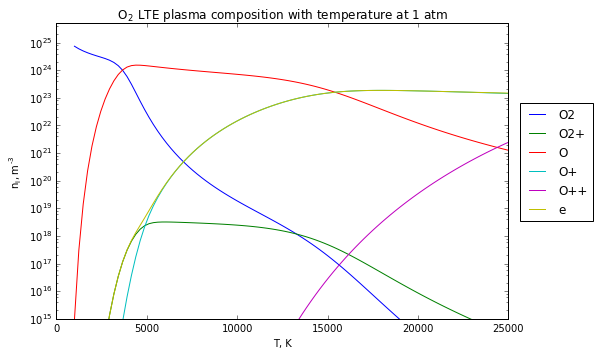

In [81]:
fig, ax0 = plt.subplots(1, 1, figsize=(7.5, 5))
ax0.set_title("$\mathregular{O_2}$ LTE plasma composition with temperature at 1 atm")
ax0.set_xlabel("T, K")
ax0.set_ylabel("$\mathregular{n_i, m^{-3}}$")
ax0.set_ylim(1e15, 5e25)
for spn, sn in zip(ni, speciesnames):
    ax0.semilogy(temperatures, spn, label=sn);
ax0.legend(bbox_to_anchor=(1.2, 0.75));
plt.tight_layout()

The results obtained using minplascalc compare favourably with calculations by other authors, for example Boulos et al 1994 (see README for full reference). Some small deviations occur at lower concentration levels, but since these species are at concentrations more than six orders of magnitude smaller than the dominant components, the differences in actual plasma behaviour are expected to be small.

<a id="3.4"></a>
### 3.4 Calculating the density and heat capacity of an O<sub>2</sub> plasma

[TODO]

<a id="3.5"></a>
### 3.5 Calculating equilibrium compositions of a CO-SiO plasma

[TODO]

<a id="3.6"></a>
### 3.6 Calculating the density and heat capacity of a CO-SiO plasma

[TODO]